Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

Домашнее задание
Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [1]:
##pip install gensim

In [15]:

import pandas as pd


In [16]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [17]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
##import nltk
##nltk.download()

1. Получаем векторные представления новостей

In [18]:
##pip install razdel

In [20]:
pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)

  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=83947c3e1c3c143423a8dede5878d48f7fd362ba1d9e129d1b3b8ce72e2fb226
  Stored in directory: c:\users\ane4kasssss\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [21]:
from gensim.corpora.dictionary import Dictionary

import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize

import pymorphy2

In [22]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [24]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [25]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}


def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [26]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-25-4e82f89fe8d7>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


In [27]:
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [28]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [29]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 48.1 s


In [30]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [31]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(7, 0.07362874), (19, 0.3087329), (21, 0.43960777), (22, 0.15924014)]

In [32]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год млн население тыс спрос составить компания
topic_1: год который это nn исследование свой страна
topic_2: ракета запуск активность доклад обращение журнал свидетель
topic_3: рак берег формально дед комплексный мешок дон
topic_4: вицепремьер ii ми молдавия завести снять поражать
topic_5: гражданин артист курение народный киргизия курить сигарета
topic_6: год человек который результат мужчина журнал тело
topic_7: год это наука который работа операция университет
topic_8: сотрудник полиция задержать обнаружить чиновник человек источник
topic_9: газ планета километр сектор университет параметр заведение
topic_10: военный турция космонавт боевой клинический афганистан ирак
topic_11: двигатель авария машина пилот скорость автомобиль район
topic_12: это россия мочь который российский весь человек
topic_13: болезнь тепло орден зампред заработок роды пепел
topic_14: пациент фонд убийство область белый год расчёт
topic_15: вероятно италия калифорния лестница рим развиться разногласие

In [33]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [34]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.513727,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.362148,0.0,0.000000,0.0,0.116209,0.000000,0.0,0.000000
1,4896,0.000000,0.232812,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.262061,0.0,0.125863,0.258910,0.0,0.100305
2,4897,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.079353,0.0,...,0.0,0.000000,0.000000,0.0,0.308747,0.0,0.434726,0.158383,0.0,0.000000
3,4898,0.000000,0.114001,0.0,0.0,0.06175,0.0,0.0,0.088950,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.529361,0.000000,0.0,0.000000
4,4899,0.289192,0.236515,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.054027,0.000000,0.0,0.000000,0.0,0.396872,0.000000,0.0,0.000000


In [35]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [36]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [37]:
doc_dict[293622]

array([0.11042985, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16689824, 0.        , 0.0176112 ,
       0.        , 0.        , 0.29329211, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0491654 , 0.192909  , 0.        , 0.        , 0.15876435])

In [40]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
get_user_embedding(user_articles_list)

array([0.        , 0.18965297, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05295349, 0.        , 0.        ,
       0.01404252, 0.        , 0.28219225, 0.        , 0.03098226,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03657757])

In [42]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.035697,0.178607,0.0,0.0,0.0,0.0,0.043638,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.024583,0.144076,0.000000,0.0,0.066357
1,u108690,0.032780,0.245566,0.0,0.0,0.0,0.0,0.033782,0.000000,0.00000,...,0.0,0.007229,0.0,0.0,0.0,0.000000,0.040562,0.000000,0.0,0.067187
2,u108339,0.015263,0.210793,0.0,0.0,0.0,0.0,0.042640,0.036918,0.01699,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.024456,0.066211,0.0,0.083286


In [43]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.035697,0.178607,0.0,0.0,0.0,0.0,0.043638,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.024583,0.144076,0.000000,0.0,0.066357,0
1,u108690,0.032780,0.245566,0.0,0.0,0.0,0.0,0.033782,0.000000,0.00000,...,0.007229,0.0,0.0,0.0,0.000000,0.040562,0.000000,0.0,0.067187,1
2,u108339,0.015263,0.210793,0.0,0.0,0.0,0.0,0.042640,0.036918,0.01699,...,0.000000,0.0,0.0,0.0,0.000000,0.024456,0.066211,0.0,0.083286,1


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [47]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [48]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07887698, 0.05293816, 0.34878688, 0.12180903, 0.01966191,
       0.01617539, 0.14175521, 0.29842106, 0.07437668, 0.32535369])

In [49]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Рассчитаем Precision, Recall, F_score

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.251373, F-Score=0.715, Precision=0.631, Recall=0.824


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1637  118]
 [  44  201]]


NameError: name 'itertools' is not defined

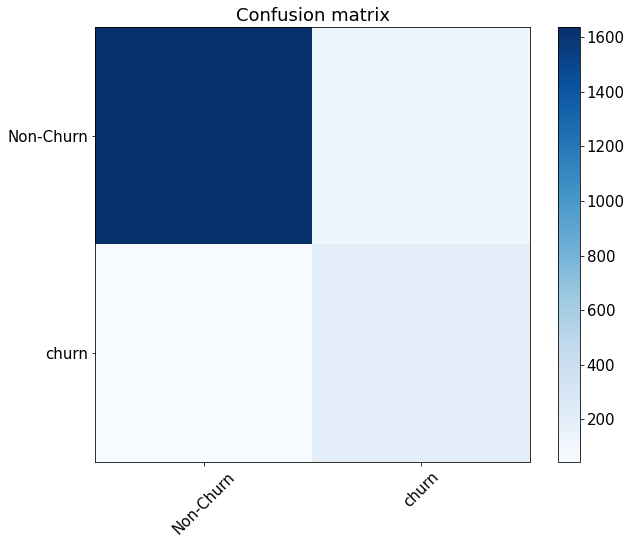

In [52]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [53]:
roc_auc_score(y_test, preds)

0.9574417117274259

Повторить п.2, но используя уже не медиану, а max

In [54]:
user_articles_list2 = users['articles'].iloc[33]

def get_user_embedding2(user_articles_list2):
    user_articles_list2 = eval(user_articles_list2)
    user_vector2 = np.array([doc_dict[doc_id] for doc_id in user_articles_list2])
    user_vector2 = np.max(user_vector2, 0)
    return user_vector2

In [55]:
get_user_embedding2(user_articles_list2)

array([0.21414119, 0.59245521, 0.01134921, 0.        , 0.        ,
       0.        , 0.06901587, 0.13441595, 0.03554617, 0.        ,
       0.1371672 , 0.01170358, 0.48846805, 0.04559107, 0.26890743,
       0.        , 0.02435286, 0.        , 0.        , 0.        ,
       0.36108378, 0.13908009, 0.24610193, 0.        , 0.54392076])

In [64]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding2(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.110430,0.511274,0.000000,0.0,0.0,0.016992,0.203149,0.166898,0.088113,...,0.037795,0.000000,0.000000,0.075110,0.159866,0.063511,0.623154,0.197814,0.000000,0.158764
1,u108690,0.073151,0.632725,0.012922,0.0,0.0,0.000000,0.071421,0.034520,0.105384,...,0.000000,0.058828,0.000000,0.000000,0.055860,0.032859,0.170032,0.214498,0.011681,0.205408
2,u108339,0.057420,0.672447,0.016060,0.0,0.0,0.000000,0.302933,0.079827,0.121845,...,0.000000,0.031477,0.025237,0.013761,0.029108,0.143355,0.258337,0.165430,0.076177,0.172301


In [65]:
target2 = pd.read_csv("users_churn.csv")
target2.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [66]:
X2 = pd.merge(user_embeddings2, target2, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.110430,0.511274,0.000000,0.0,0.0,0.016992,0.203149,0.166898,0.088113,...,0.000000,0.000000,0.075110,0.159866,0.063511,0.623154,0.197814,0.000000,0.158764,0
1,u108690,0.073151,0.632725,0.012922,0.0,0.0,0.000000,0.071421,0.034520,0.105384,...,0.058828,0.000000,0.000000,0.055860,0.032859,0.170032,0.214498,0.011681,0.205408,1
2,u108339,0.057420,0.672447,0.016060,0.0,0.0,0.000000,0.302933,0.079827,0.121845,...,0.031477,0.025237,0.013761,0.029108,0.143355,0.258337,0.165430,0.076177,0.172301,1


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [68]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [69]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.33127003e-01, 1.91627233e-04, 6.81366781e-01, 2.85082735e-01,
       1.70275947e-01, 2.12615069e-03, 2.20608289e-01, 1.21796054e-01,
       1.46231938e-03, 1.26194017e-01])

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.301702, F-Score=0.717, Precision=0.711, Recall=0.722


Confusion matrix, without normalization
[[1683   72]
 [  69  176]]


NameError: name 'itertools' is not defined

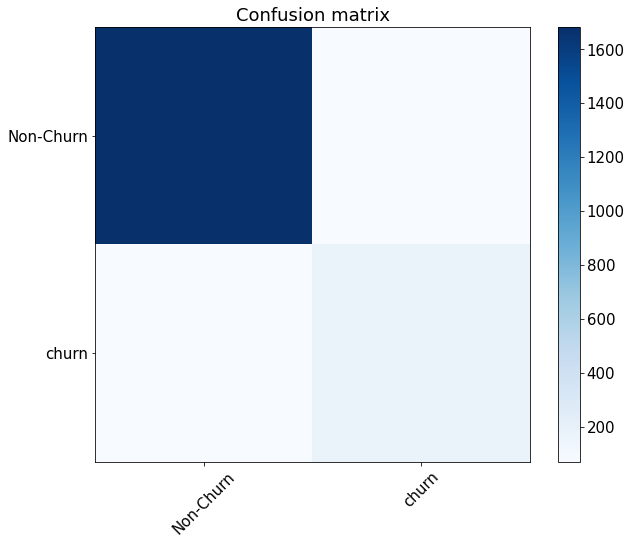

In [71]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [72]:
roc_auc_score(y_test, preds)

0.9472783301354728

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [73]:
tabledata = [["mean", 0.696, 6.651, 0.747, 0.95079],
             ["median", 0.715, 0.631, 0.824, 0.95744],
             ["max", 0.717, 0.711, 0.722, 0.09472]]

In [74]:
pd.DataFrame(tabledata, columns = ["метод","F-score", "Precision", "Recall", "roc_auc_score"])

,метод,F-score,Precision,Recall,roc_auc_score
0,mean,0.696,6.651,0.747,0.95079
1,median,0.715,0.631,0.824,0.95744
2,max,0.717,0.711,0.722,0.09472


При использовании подхода с использованием медианы хорошее значение имеет Recall и roc_auc_score,данный метод наиболее эффективен.